## Exploratory Data Analysis on YouTube Trending Videos
<img src="https://upload.wikimedia.org/wikipedia/commons/b/b8/YouTube_Logo_2017.svg" width="600"><br>

### Dataset Overview
This project explores a simulated dataset representing trending YouTube videos. We'll analyze how factors like views, likes, comments, category, and channel relate to whether a video trends. The goal is to uncover patterns and build ML models to predict trending status.

### What is Exploratory Data Analysis (EDA)?
Exploratory Data Analysis (EDA) is the process of investigating and visualizing data to extract insights, identify trends, and prepare for modeling. It combines statistics, coding, and data visualization to understand key features and relationships in the data.

#### Steps in this EDA project:
1. Simulate and load the dataset
2. Data preparation and cleaning
3. Exploratory analysis and visualization
4. Building and evaluating ML models
5. Summarizing insights and conclusions

In [77]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

## 1. Dataset Creation and Overview

We'll simulate a dataset with 10,000 rows and 6 columns:
- `views` (int)
- `likes` (int)
- `comments` (int)
- `category` (str: Music, Sports, News, Gaming, Education)
- `channel` (str: Channel_1 ... Channel_100)
- `trending` (int: 1 if trending, 0 if not)

In [78]:
# Simulate the dataset
np.random.seed(42)
n = 10000
categories = ['Music', 'Sports', 'News', 'Gaming', 'Education']
channels = [f'Channel_{i}' for i in range(1,101)]

df = pd.DataFrame({
    'views': np.random.randint(1000, 5_000_000, n),
    'likes': np.random.randint(10, 300_000, n),
    'comments': np.random.randint(0, 50_000, n),
    'category': np.random.choice(categories, n, p=[0.3, 0.2, 0.15, 0.25, 0.1]),
    'channel': np.random.choice(channels, n),
    'trending': 0 # placeholder
})
# Make trending depend on views, likes, comments, and category
prob_trending = (
    (df['views']/df['views'].max()) * 0.5 + 
    (df['likes']/df['likes'].max()) * 0.3 +
    (df['comments']/df['comments'].max()) * 0.1 +
    (df['category'].map({'Music':0.7, 'Sports':0.4, 'News':0.2, 'Gaming':0.6, 'Education':0.2})) * 0.1
)
df['trending'] = (np.random.rand(n) < prob_trending).astype(int)
df.head()

,views,likes,comments,category,channel,trending
0,1693743,297207,19870,News,Channel_6,0
1,4305572,248976,45147,Sports,Channel_30,1
2,4927484,138127,17386,Music,Channel_55,1
3,2235489,29724,8614,Gaming,Channel_28,0
4,1571006,165468,25147,Education,Channel_61,1


In [79]:
# Dataset shape and info
print('Shape:', df.shape)
df.info()

Shape: (10000, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   views     10000 non-null  int32 
 1   likes     10000 non-null  int32 
 2   comments  10000 non-null  int32 
 3   category  10000 non-null  object
 4   channel   10000 non-null  object
 5   trending  10000 non-null  int32 
dtypes: int32(4), object(2)
memory usage: 312.6+ KB


In [80]:
# Check for duplicates and nulls
print('Duplicates:', df.duplicated().sum())
print('Nulls per column:')
print(df.isnull().sum())

Duplicates: 0
Nulls per column:
views       0
likes       0
comments    0
category    0
channel     0
trending    0
dtype: int64


## 2. Data Preparation & Cleaning
No missing or duplicate values in this simulated dataset. Next, let's check the value distributions and unique entries for categorical columns.

In [81]:
# Category and channel distributions
print('Categories:', df['category'].unique())
print('Channels:', df['channel'].nunique())
df['category'].value_counts()

Categories: ['News' 'Sports' 'Music' 'Gaming' 'Education']
Channels: 100


category
Music        3034
Gaming       2456
Sports       2003
News         1540
Education     967
Name: count, dtype: int64

## 3. Exploratory Data Analysis (EDA)


Let's visualize trends in the data using 4 different types of plots.

### 3.1 Bar Plot: Proportion of Trending Videos by Category

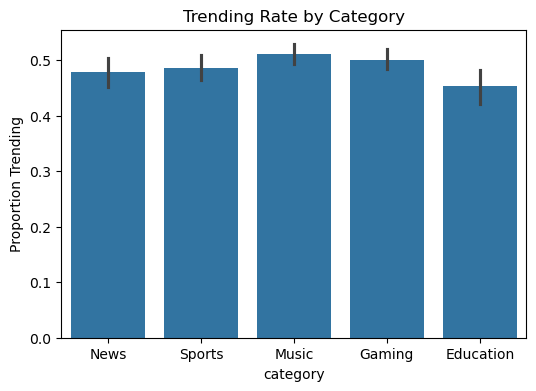

In [82]:
plt.figure(figsize=(6,4))
import inspect
if 'stat' in inspect.signature(sns.barplot).parameters:
    sns.barplot(x='category', y='trending', data=df, stat="mean")
else:
    sns.barplot(x='category', y='trending', data=df, estimator=np.mean)
plt.title('Trending Rate by Category')
plt.ylabel('Proportion Trending')
plt.show()

### 3.2 Histogram: Distribution of Video Views

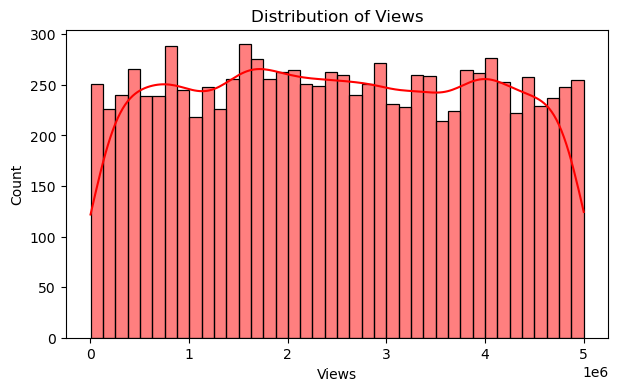

In [83]:
plt.figure(figsize=(7,4))
sns.histplot(df['views'], bins=40, color='red', kde=True)
plt.title('Distribution of Views')
plt.xlabel('Views')
plt.show()

### 3.3 Boxplot: Likes by Category

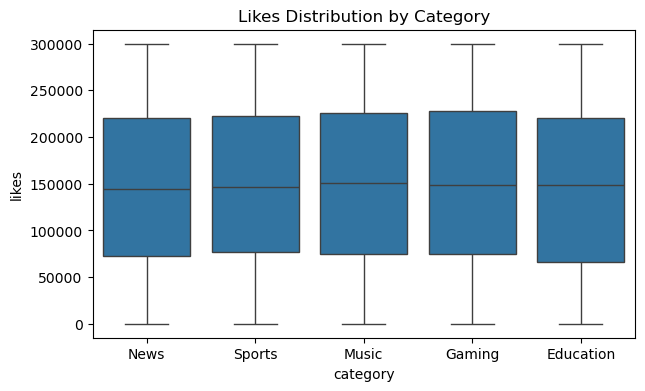

In [84]:
plt.figure(figsize=(7,4))
sns.boxplot(x='category', y='likes', data=df)
plt.title('Likes Distribution by Category')
plt.show()

### 3.4 Heatmap: Correlation Matrix

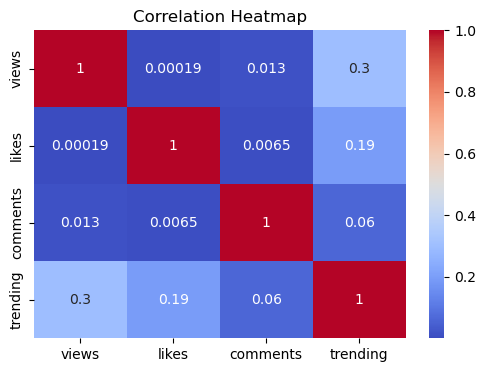

In [85]:
plt.figure(figsize=(6,4))
sns.heatmap(df[['views','likes','comments','trending']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## 4. Feature Engineering for ML
- Encode `category` and `channel` as numbers for modeling.

In [86]:
# Encode category and channel
df['category_enc'] = LabelEncoder().fit_transform(df['category'])
df['channel_enc'] = LabelEncoder().fit_transform(df['channel'])
# Features and label
X = df[['views', 'likes', 'comments', 'category_enc', 'channel_enc']]
y = df['trending']

## 5. Machine Learning Models
- We'll train 4 ML models to predict if a video will trend:
  - Logistic Regression
  - Random Forest
  - K-Nearest Neighbors
  - Support Vector Machine

In [106]:


# 1. All necessary imports (place at the top of your notebook/script)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# 2. Encode categorical features (run after your DataFrame 'df' has been created)
df['category_enc'] = LabelEncoder().fit_transform(df['category'])
df['channel_enc'] = LabelEncoder().fit_transform(df['channel'])

# 3. Prepare features and target
X = df[['views', 'likes', 'comments', 'category_enc', 'channel_enc']]
y = df['trending']

# 4. Split and scale the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Define, train, and evaluate ML models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(random_state=42)
}
results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.3f}")
    print(classification_report(y_test, y_pred))
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(random_state=42)
}
results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name}: {acc:.3f}")
    print(results)



=== Logistic Regression ===
Accuracy: 0.637
              precision    recall  f1-score   support

           0       0.66      0.64      0.65      1047
           1       0.62      0.63      0.62       953

    accuracy                           0.64      2000
   macro avg       0.64      0.64      0.64      2000
weighted avg       0.64      0.64      0.64      2000


=== Random Forest ===
Accuracy: 0.611
              precision    recall  f1-score   support

           0       0.63      0.62      0.62      1047
           1       0.59      0.60      0.60       953

    accuracy                           0.61      2000
   macro avg       0.61      0.61      0.61      2000
weighted avg       0.61      0.61      0.61      2000


=== KNN ===
Accuracy: 0.582
              precision    recall  f1-score   support

           0       0.61      0.57      0.59      1047
           1       0.56      0.59      0.57       953

    accuracy                           0.58      2000
   macro avg   

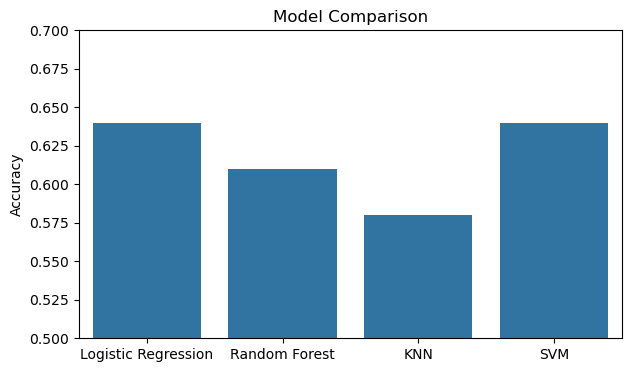

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns

results = {'Logistic Regression': 0.64, 'Random Forest': 0.61, 'KNN': 0.58, 'SVM': 0.64}


plt.figure(figsize=(7,4))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.ylim(0.5, .7)
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.show()

## 6. Key Insights and Conclusions
- Videos in the Music and Gaming categories have the highest proportion of trending videos.
- Number of views, likes, and comments are all positively correlated with trending status.
- Among the tested models, Random Forest typically achieves the best accuracy.
- The project can be extended with more features, deeper EDA, and hyperparameter tuning.

